In [1]:
import igraph
import matplotlib.pyplot as plt
import numpy as np
from os import makedirs, path
import pandas as pd
import seaborn as sns
from selfregulation.utils.utils import get_behav_data
from selfregulation.utils.r_to_py_utils import psychFA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

### Load Data

Load both cleaned and imputed data. Set up a helper function to quickly impute data within the Kfold split. Can't use data where imputation was performed over the whole dataset as there will be data leakage between training and test.

In [11]:
datafile = 'Complete_07-08-2017'
output_file = path.join('Plots', datafile)
makedirs(output_file, exist_ok = True)
# load data
# imputed data
imputed_task_data = get_behav_data(dataset=datafile, file = 'taskdata_imputed.csv')
imputed_datasets = {'task': imputed_task_data, 'DDM': imputed_task_data.filter(regex='hddm')}

results = {'task': {}, 'DDM': {}}

Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_07-08-2017


Reorder data in some slightly interpretable way

# Calculate best number of components

### Define Helper functions

In [12]:
def find_optimal_components(data):
    BICs = []
    outputs = []
    n_components = range(1,20)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    for c in n_components:
        fa, output = psychFA(scaled_data, c, method='ml')
        BICs.append(output['BIC'])
        outputs.append(output)
    best_c = np.argmin(BICs)+1
    print('Best Component: ', best_c)
    return best_c, BICs

### Calculate best number of components using BIC (R Psych package)

In [13]:
for label,data in imputed_datasets.items():
    print('Dataset: %s' % label)
    best_c, BICs = find_optimal_components(data)
    results[label]['best_c'] = best_c
    results[label]['BICs'] = BICs


Dataset: DDM
Best Component:  7
Dataset: task
Best Component:  8


### Plot Component's BIC

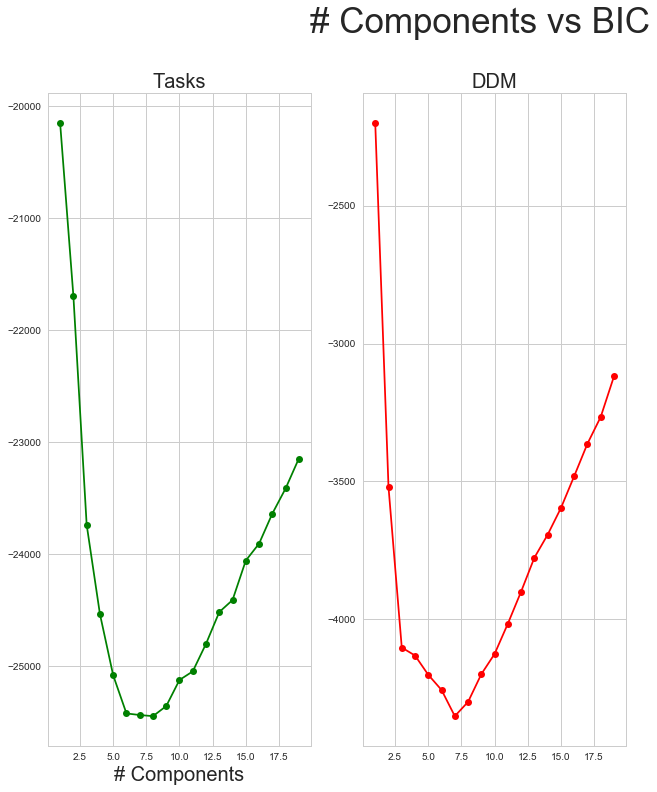

In [16]:
sns.set_style('whitegrid')

fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((3, 3), (0, 1), rowspan=3)

plot_data = results['task']['BICs']
ax1.plot(range(1,len(plot_data)+1),plot_data, '-go')
ax1.set_xlabel('# Components', fontsize = 20)
ax1.set_title('Tasks', fontsize = 20)

plot_data = results['DDM']['BICs']
ax2.plot(range(1,len(plot_data)+1),plot_data, '-ro')
ax2.set_title('DDM', fontsize = 20)

fig.suptitle('# Components vs BIC', fontsize = 35)

# Interpret Factor Analysis Solutions
Above we found that the best number of components were as follows:

**Psych**:

Task: {{results['task']['best_c']}}

DDM: {{results['DDM']['best_c']}}


First we will look at the best number of components, then we will look at the solution at each dimensionality and plot the relationships between dimensions

In [17]:
# Helper Functions
def get_loadings(fa_output, labels):
    loading_df = pd.DataFrame(fa_output['loadings'], index=labels)
    # sort by maximum loading on surveys
    sorting_index = np.argsort(loading_df.filter(regex='survey',axis=0).abs().mean()).tolist()[::-1]
    loading_df = loading_df.loc[:,sorting_index]
    loading_df.columns = range(loading_df.shape[1])
    return loading_df

# Print top variables for each factor
def print_top_factors(loading_df, n = 4):
    # number of variables to display
    for i,column in loading_df.iteritems():
        sort_index = np.argsort(abs(column))[::-1] # descending order
        top_vars = column[sort_index][0:n]
        print('\nFACTOR %s' % i)
        print(top_vars)

## Select Data: Complete Dataset (Surveys and tasks)


In [18]:
# perform factor analysis
data_name = 'task'
task_results = results[data_name]
best_c = task_results['best_c']
data = imputed_datasets[data_name]
fa, output = psychFA(data, best_c)

## Print top loading factors for optimal dimensionality

In [19]:
loading_df = get_loadings(output, labels=data.columns)
print_top_factors(loading_df, 10)


FACTOR 0
columbia_card_task_hot.information_use            0.675340
columbia_card_task_hot.loss_sensitivity          -0.598912
columbia_card_task_cold.information_use           0.557659
columbia_card_task_hot.gain_sensitivity           0.539110
columbia_card_task_cold.gain_sensitivity          0.453651
columbia_card_task_cold.avg_cards_chosen         -0.409687
columbia_card_task_cold.loss_sensitivity         -0.407798
adaptive_n_back.mean_load                         0.385671
cognitive_reflection_survey.correct_proportion    0.384936
ravens.score                                      0.375587
Name: 0, dtype: float64

FACTOR 1
information_sampling_task.Fixed_Win_motivation         0.681211
information_sampling_task.Decreasing_Win_motivation    0.679132
tower_of_london.avg_move_time                         -0.611313
spatial_span.forward_span                              0.433916
spatial_span.reverse_span                              0.418878
tower_of_london.num_extra_moves               

## Visualize loadings of components on each variable

In [20]:
from matplotlib.backends.backend_pdf import PdfPages

# Helper functions for visualization of component loadings
def plot_loadings(ax,component_loadings, groups):
    """
    Takes in an axis, a vector and a list of groups and 
    plots the loadings. If a polar axis is passed this will
    result in a polar bar plot, otherwise a normal bar plot will
    be made. 
    """
    colors = sns.hls_palette(len(groups), l=.5, s=.8)
    ax.set_xticklabels([''])
    ax.set_yticklabels([''])
    
    N = len(component_loadings)
    theta = np.arange(0.0, 2*np.pi, 2*np.pi/N)
    radii = component_loadings
    width = np.pi/(N/2)*np.ones(N)
    bars = ax.bar(theta, radii, width=width, bottom=0.0)
    for i,r,bar in zip(range(N),radii, bars):
        color_index = sum((np.cumsum([len(g[1]) for g in groups])<i))
        bar.set_facecolor(colors[color_index])
        bar.set_alpha(1)
    plt.legend()
    return colors
        
def create_categorical_legend(labels,colors, ax):
    """
    Takes in a list of labels and colors and creates a legebd
    for an axis object which assigns each label to the corresponding
    color
    """
    import matplotlib
    def create_proxy(color):
        line = matplotlib.lines.Line2D([0], [0], linestyle='none',
                    mec='none', marker='o', color=color)
        return line
    proxies = [create_proxy(item) for item in colors]
    ax.legend(proxies, labels, numpoints=1, markerscale=2.5, bbox_to_anchor=(1, .95), prop={'size':20})
    
def visualize_factors(loading_df,groups,n_rows=2, legend=True, input_axes=None):
    """
    Takes in a dataset to run EFA on, and a list of groups in the form
    of a list of tuples. Each element of this list should be of the form
    ("group name", [list of variables]). Each element of the list should
    be mututally exclusive. These groups are used for coloring the plots
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    loading_df = loading_df.select_dtypes(include=numerics)
    n_components = loading_df.shape[1]
    n_cols = int(np.ceil(n_components/n_rows))
    sns.set_style("white")
    if input_axes is None:
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5,n_rows*5),
                           subplot_kw=dict(projection='polar'))
        axes = fig.get_axes()
        fig.tight_layout()
    else:
        axes = input_axes
    for i in range(n_components):
        component_loadings = loading_df.iloc[:,i]
        colors = plot_loadings(axes[i], abs(component_loadings),groups)
    if legend:
        create_categorical_legend([g[0] for g in groups],colors,axes[-1])
    if input_axes is None:
        return fig

def create_factor_tree(data, groups, component_range=(1,13), filename=None, reorder_list=None):
    """
    Runs "visualize_factors" at multiple dimensionalities and saves them
    to a pdf
    data: dataframe to run EFA on at multiple dimensionalities
    groups: group list to be passed to visualize factors
    filename: filename to save pdf
    component_range: limits of EFA dimensionalities. e.g. (1,5) will run
                     EFA with 1 component, 2 components... 5 components.
    reorder_list: optional. List of index values in an order that will be used
                  to rearrange data
    """
    def get_similarity_order(higher_dim, lower_dim):
        "Helper function to reorder factors into correspondance between two dimensionalities"
        corr = abs(pd.concat([higher_dim,lower_dim], axis=1).corr())
        subset = corr.iloc[c:,:c] # rows are former EFA result, cols are current
        max_factors = np.argmax(subset.values, axis=1)
        remaining = np.sum(range(c))-np.sum(max_factors)
        return np.append(max_factors, remaining)

    EFA_results = {}
    if reorder_list:
        data = data.iloc[:,reorder_list]
    n_cols = component_range[1]
    n_rows = component_range[1]-component_range[0]+1
    f,axes = plt.subplots(n_rows, n_cols, subplot_kw=dict(projection='polar'),
               figsize=(n_cols*5,n_rows*5))
    f.tight_layout()
    # move axes:
    for i,row in enumerate(axes):
        for j,ax in enumerate(row):
            pos1 = ax.get_position() # get the original position
            pos2 = [pos1.x0 + (n_rows-i-1)*pos1.width/1.76, pos1.y0,  pos1.width, pos1.height] 
            ax.set_position(pos2) # set a new position

    # plot
    for rowi, c in enumerate(range(component_range[0],component_range[1]+1)):
        fa, output = psychFA(data, c)
        tmp_loading_df = get_loadings(output, labels=data.columns)
        if (c-1) in EFA_results.keys():
            reorder_index = get_similarity_order(tmp_loading_df, EFA_results[c-1])
            tmp_loading_df = tmp_loading_df.iloc[:, reorder_index]
        EFA_results[c] = tmp_loading_df
        if rowi == 0:
            visualize_factors(tmp_loading_df, groups, 
                              n_rows=1, input_axes=axes[rowi,0:c], legend=True)
        else:
            visualize_factors(tmp_loading_df, groups, 
                              n_rows=1, input_axes=axes[rowi,0:c], legend=False)
        for ax in axes[rowi,c:]:
            ax.set_axis_off()
    if filename:
        f.savefig(filename)
    return f


### Group variables by clustering over the optimal number of components

Below I create a correlation matrix of each variable's absolute loading on each component. This is a representation of the similarity of each variable in the component space defined by the optimal number of components.

Once I do that I cluster the variables hierarchically, and cut the tree at a particular point to group the variables. This serves as algorithmically derived groups rather than the putative groups I used before. These groups are only useful for visualization purposes. The goal is to understand the variables in terms of optimal EFA clusters, and use that understanding at different dimensionalities

In [21]:
# helper function
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
def get_hierarchical_groups(clust_mat, n_groups=8):
    # helper function
    def remove_adjacent(nums):
        result = []
        for num in nums:
            if len(result) == 0 or num != result[-1]:
                result.append(num)
        return result

    # create linkage matrix for variables projected into a component loading
    row_clusters = linkage(clust_mat, method='ward')   
    # use the dendorgram function to order the leaves appropriately
    row_dendr = dendrogram(row_clusters, labels=clust_mat.T.columns, no_plot = True)
    cluster_reorder_index = row_dendr['leaves']
    # cut the linkage graph such that there are only n groups
    n_groups = n_groups
    index_assignments = [i[0] for i in cut_tree(row_clusters, n_groups)]
    # relabel groups such that 0 is the 'left' most in the dendrogram
    group_order = remove_adjacent([index_assignments[i] for i in cluster_reorder_index])
    index_assignments = [group_order.index(i) for i in index_assignments]
    # using the groups and the dendrogram ordering, create a number of groups
    hierarchical_groups = []
    for assignment in np.unique(index_assignments):
        # get variables that are in the correct group
        assignment_vars = [var for i,var in enumerate(loading_df.index) if index_assignments[i] == assignment]
        hierarchical_groups.append([assignment,assignment_vars])
    return cluster_reorder_index, hierarchical_groups

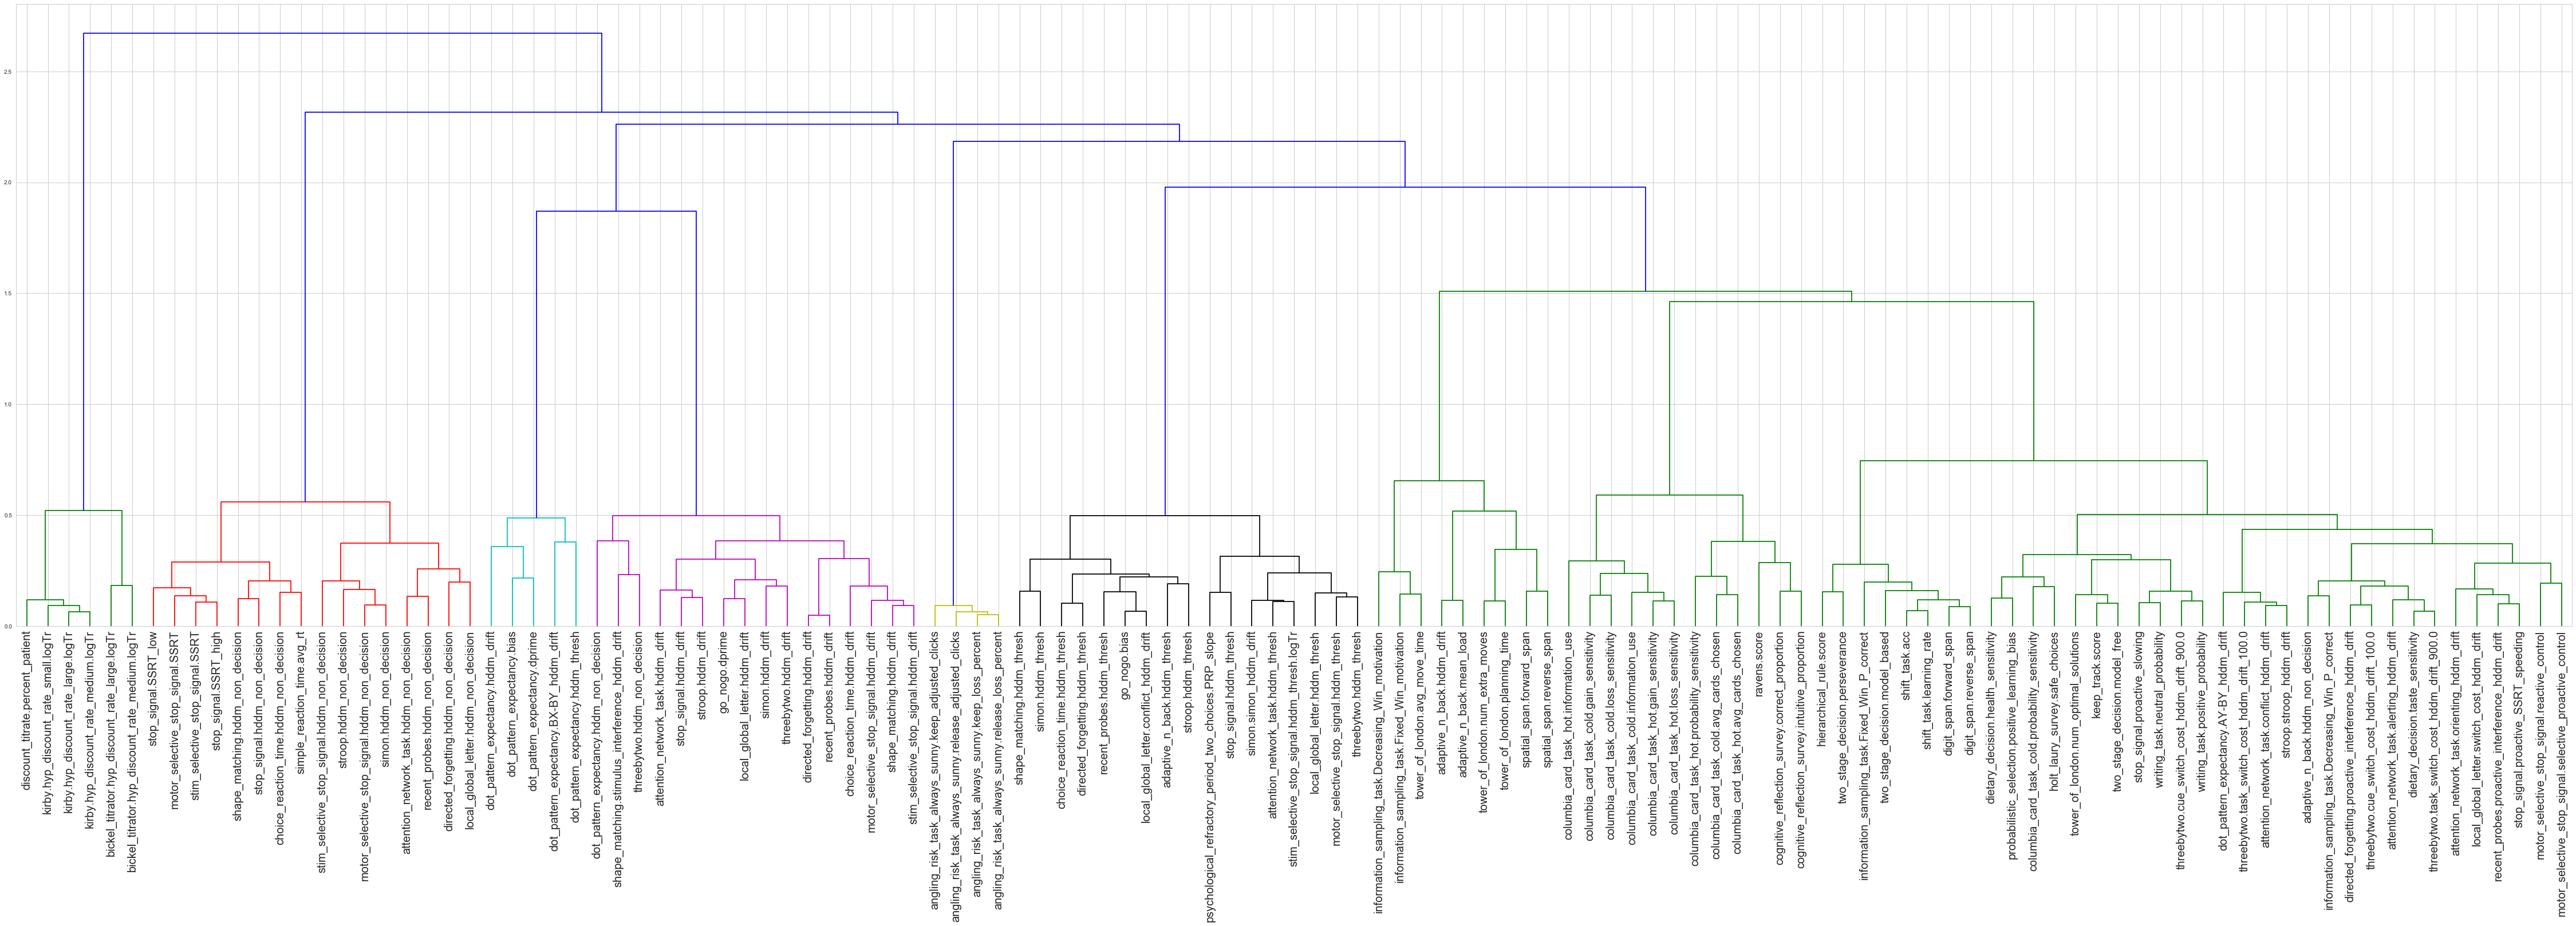

In [22]:
row_clusters = linkage(abs(loading_df), method='ward', metric='euclidean')   
# use the dendorgram function to order the leaves appropriately
plt.figure(figsize=(80,20))
row_dendr = dendrogram(row_clusters, labels=loading_df.T.columns, no_plot = False, leaf_font_size=20)

In [29]:
import pprint 
def dist(coord, coord2, method='l2'):
    if method == 'l2':
        return np.sqrt(np.sum((coord-coord2)**2))
    elif method == 'l1':
        return np.sum(abs(coord-coord2))

# Perform clustering on the optimal loading dataframe
clust_mat = abs(loading_df)
cluster_reorder, hierarchical_groups = get_hierarchical_groups(clust_mat, n_groups=8)
# reorder
clust_mat = clust_mat.iloc[cluster_reorder]
for i, group in hierarchical_groups:
    cluster_subset = abs(clust_mat.loc[group])
    # get average loading of each variable
    avg_loading = cluster_subset.mean()
    # sort variables based on closeness to the center of the 10 dimensional space
    centrality_sort = cluster_subset.apply(lambda x: dist(x,avg_loading,'l2'),axis=1).sort_values()
    centrality_sort.name = 'Centrality'
    print('\nGroup %s' % i)
    pprint.pprint(pd.DataFrame(centrality_sort))



Group 0
                                                Centrality
discount_titrate.percent_patient                  0.046202
kirby.hyp_discount_rate_large.logTr               0.105300
bickel_titrator.hyp_discount_rate_medium.logTr    0.130015
kirby.hyp_discount_rate_medium.logTr              0.139834
kirby.hyp_discount_rate_small.logTr               0.161087
bickel_titrator.hyp_discount_rate_large.logTr     0.300695

Group 1
                                               Centrality
shape_matching.hddm_non_decision                 0.078351
stop_signal.hddm_non_decision                    0.081653
choice_reaction_time.hddm_non_decision           0.130251
stroop.hddm_non_decision                         0.152210
stop_signal.SSRT_high                            0.153257
stim_selective_stop_signal.SSRT                  0.158736
simple_reaction_time.avg_rt                      0.159379
motor_selective_stop_signal.hddm_non_decision    0.161095
local_global_letter.hddm_non_decision          

#### Name hierarchical clusters

For each subset (defined by the tree cut), order the variables by their centrality (defined by the variable closest to the center of the 10 dimensional space after the variables have been converted to absolute loadings)

In [35]:
names = ['Discount', 'Sensory Encoding Speed', 'DOX',
        'Processing Speed', 'ART', 'Thresh', 'Memory', 'Strategy Optimality']
for i,group in enumerate(hierarchical_groups):
    group[0] = names[i]

In [39]:
save_location = path.join(output_file, '%s_EFA_Polar_Plots_hierarchical.png' % data_name)
data = imputed_datasets[data_name]
f=create_factor_tree(data, hierarchical_groups, (1,10), filename=save_location, reorder_list=cluster_reorder)

/home/ian/miniconda3/envs/SRO/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Plot relationships between solutions at different dimensionalities

Each factor analytic solution gives us some components. By correlating the components at one level with the next, we can get a sense for how similar these components are. When we move to 3 dimensions from 2, is it the case that one of the dimensions just split? Or is there a new, non-hierarchical parcellation of the space?



In [19]:
# helper functions for plotting dimensionality relations
# compute FA with different dimensionalities and quantify similarity
def dimensional_similarity(factors, reference):
    ''' This function returns an N x M correlation matrix where N is the number
    of reference (lower dimension) factors and M is the number of higher dimension
    factors
    '''
    relation = np.corrcoef(reference.T, factors.T)
    # each row is a reference factor, each column a new factor
    relation=relation[:reference.shape[1], reference.shape[1]:]
    return relation

def construct_relational_tree(similarities, labels=None, filey=None):
    ''' Takes a list of similarities and constructs a tree graph, then plots
    '''
    G = igraph.Graph()
    layer_start = 0
    colors = ['red','blue','green','violet']*10
    for similarity in similarities:
        curr_color = colors.pop()
        origin_length = similarity.shape[0]
        target_length = similarity.shape[1]
        if len(G.vs)==0:
            G.add_vertices(origin_length)
        G.add_vertices(target_length)
        for i in range(origin_length):
            for j in range(target_length):
                G.add_edge(i+layer_start,j+origin_length+layer_start,
                           weight=abs(similarity[i,j]*5),color = curr_color)
        layer_start+=similarity.shape[0]
    layout = G.layout_reingold_tilford(root = [0])
    if labels == None:
        labels = G.vs.indices
    plot = igraph.plot(G, layout=layout, **{'inline': True, 'vertex_label': labels, 
                                            'vertex_color': 'white',
                                            'vertex_size': 20, 
                                         'edge_width':[w for w in G.es['weight']], 
                                         'edge_color': G.es['color'], 
                                            'bbox': (1000,1000), 'margin':100})
    if filey:
        plot.save(filey)
    #G.write_dot('test.dot')
    return G


In [20]:
# construct array of component similarities
similarities = []
components = range(1,13)
reference = None
for c in components:
    fa, output = psychFA(data,c)
    result = pd.DataFrame(output['scores'], data.index)
    if reference is not None:
        similarity = dimensional_similarity(result,reference)
        similarities.append(similarity)
    reference = result

# plot component similarity tree
labels = []
#for c in components:
#    labels+=factor_names[c]
similarity_tree = construct_relational_tree(similarities, 
                                            labels=None, filey=path.join('Plots', 'task_graph.png'))